In [2]:
!pip install numpy pandas scikit-learn imbalanced-learn nltk spacy
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip install transformers datasets evaluate accelerate joblib shap
!pip install streamlit fastapi uvicorn pydantic
!python -m spacy download en_core_web_sm


Looking in indexes: https://download.pytorch.org/whl/cpu
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 80.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 106.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 72.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [22]:
from google.colab import files
uploaded = files.upload()

Saving fake-news-detection-metadata.json to fake-news-detection-metadata.json


In [23]:
import os

for root, dirs, files in os.walk("data"):
    for file in files:
        print(os.path.join(root, file))


data/FakeNewsNet.csv


In [25]:
import pandas as pd

df = pd.read_csv("data/FakeNewsNet.csv")
print(df.head())
print(df.columns)


                                               title  \
0  Kandi Burruss Explodes Over Rape Accusation on...   
1  People's Choice Awards 2018: The best red carp...   
2  Sophia Bush Sends Sweet Birthday Message to 'O...   
3  Colombian singer Maluma sparks rumours of inap...   
4  Gossip Girl 10 Years Later: How Upper East Sid...   

                                            news_url        source_domain  \
0  http://toofab.com/2017/05/08/real-housewives-a...           toofab.com   
1  https://www.today.com/style/see-people-s-choic...        www.today.com   
2  https://www.etonline.com/news/220806_sophia_bu...     www.etonline.com   
3  https://www.dailymail.co.uk/news/article-33655...  www.dailymail.co.uk   
4  https://www.zerchoo.com/entertainment/gossip-g...      www.zerchoo.com   

   tweet_num  real  
0         42     1  
1          0     1  
2         63     1  
3         20     1  
4         38     1  
Index(['title', 'news_url', 'source_domain', 'tweet_num', 'real'], dtype='

In [26]:
# Keep only the important columns
df = df[['title', 'real']]

# Rename for clarity
df = df.rename(columns={'title': 'text', 'real': 'label'})

print(df.head())
print(df['label'].value_counts())


                                                text  label
0  Kandi Burruss Explodes Over Rape Accusation on...      1
1  People's Choice Awards 2018: The best red carp...      1
2  Sophia Bush Sends Sweet Birthday Message to 'O...      1
3  Colombian singer Maluma sparks rumours of inap...      1
4  Gossip Girl 10 Years Later: How Upper East Sid...      1
label
1    17441
0     5755
Name: count, dtype: int64


In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Use only text + label
df = df[['text', 'label']]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

# Text to numeric (TF-IDF)
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

# Predictions
y_pred = model.predict(X_test_tfidf)

# Results
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.844396551724138
              precision    recall  f1-score   support

           0       0.80      0.50      0.61      1151
           1       0.85      0.96      0.90      3489

    accuracy                           0.84      4640
   macro avg       0.83      0.73      0.76      4640
weighted avg       0.84      0.84      0.83      4640



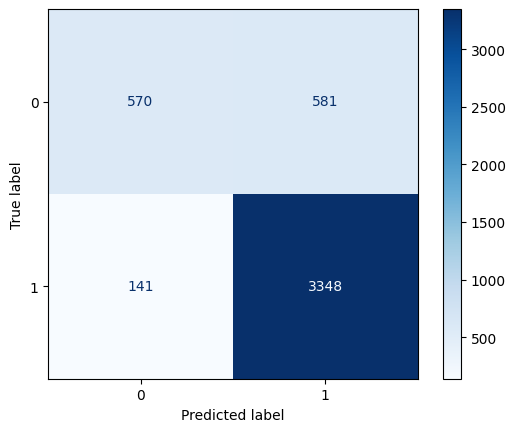

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.show()


In [30]:
def predict_news(text):
    text_tfidf = vectorizer.transform([text])
    pred = model.predict(text_tfidf)[0]
    return "Real News " if pred == 1 else "Fake News "

# Example
print(predict_news("Breaking: NASA confirms life on Mars!"))


Real News 


In [31]:
import joblib

joblib.dump(model, "fake_news_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")


['tfidf_vectorizer.pkl']

In [32]:
model = joblib.load("fake_news_model.pkl")
vectorizer = joblib.load("tfidf_vectorizer.pkl")
